<a href="https://colab.research.google.com/github/lucifer3000/rishabhk/blob/master/Copy_of_transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import pandas as pd
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from google.colab.patches import cv2_imshow
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [4]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"rishabh0100","key":"9f09a8891aad2dc73c466265559cbe66"}'}

In [6]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:

! chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d datamunge/sign-language-mnist

 80% 50.0M/62.6M [00:00<00:00, 44.0MB/s]
100% 62.6M/62.6M [00:00<00:00, 67.9MB/s]


In [11]:
!unzip sign-language-mnist.zip

Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [12]:
import pandas as pd
data = pd.read_csv('sign_mnist_train.csv')
print(data)


       label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0          3     107     118     127  ...       206       204       203       202
1          6     155     157     156  ...       175       103       135       149
2          2     187     188     188  ...       198       195       194       195
3          2     211     211     212  ...       225       222       229       163
4         13     164     167     170  ...       157       163       164       179
...      ...     ...     ...     ...  ...       ...       ...       ...       ...
27450     13     189     189     190  ...       234       200       222       225
27451     23     151     154     157  ...       195       195       195       194
27452     18     174     174     174  ...       203       202       200       200
27453     17     177     181     184  ...        47        64        87        93
27454     23     179     180     180  ...       197       205       209       215

[27455 rows x 7

In [0]:
!mkdir output

In [0]:
!mkdir output_train

In [0]:
!mkdir example

In [0]:
def show_image(image, label):
  plt.imshow(image)
  plt.title(f"class:{label}")

In [20]:
class HandDetectionDataset(Dataset):

  def __init__(self, csv_file, transform=None):
    self.data = pd.read_csv(csv_file)
    self.transform = transform

  def __len__(self):
      return len(self.data)  

  def __getitem__(self,idx):
    img_name = data.iloc[idx, 0]
    pixels = data.iloc[idx, 1:]
    pixels = np.asarray(pixels)
    pixels = pixels.astype('float').reshape(28,28)
    file_name=f"example/image_{idx}.jpg"
    cv2.imwrite(file_name,pixels)
    image = cv2.imread(file_name)
    sample = {'image': image, 'label': img_name}

    if self.transform:
      sample = self.transform(sample)

    return sample      

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


0 (28, 28, 3)
1 (28, 28, 3)
2 (28, 28, 3)
3 (28, 28, 3)


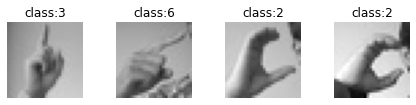

In [21]:
hand_dataset_train = HandDetectionDataset(csv_file='sign_mnist_train.csv')

fig = plt.figure()

for i in range(4):
    sample = hand_dataset_train[i]

    print(i, sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_image(**sample)         #**sample is a dictionary which unpacks image and landmarks
    if(i==3):
      plt.show()
      break

In [0]:
hand_dataset_test = HandDetectionDataset(csv_file='sign_mnist_test.csv')

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, img_name = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label':img_name }


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, img_name = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'label': img_name}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.as_tensor(label)}

(256, 256, 3)


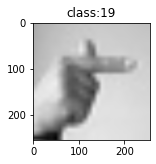

tensor([[[0.6773, 0.6773, 0.6773],
         [0.6740, 0.6740, 0.6740],
         [0.6708, 0.6708, 0.6708],
         ...,
         [0.7652, 0.7652, 0.7652],
         [0.7656, 0.7656, 0.7656],
         [0.7660, 0.7660, 0.7660]],

        [[0.6762, 0.6762, 0.6762],
         [0.6729, 0.6729, 0.6729],
         [0.6696, 0.6696, 0.6696],
         ...,
         [0.7643, 0.7643, 0.7643],
         [0.7647, 0.7647, 0.7647],
         [0.7652, 0.7652, 0.7652]],

        [[0.6751, 0.6751, 0.6751],
         [0.6717, 0.6717, 0.6717],
         [0.6684, 0.6684, 0.6684],
         ...,
         [0.7634, 0.7634, 0.7634],
         [0.7639, 0.7639, 0.7639],
         [0.7643, 0.7643, 0.7643]],

        ...,

        [[0.2163, 0.2163, 0.2163],
         [0.2223, 0.2223, 0.2223],
         [0.2283, 0.2283, 0.2283],
         ...,
         [0.8519, 0.8519, 0.8519],
         [0.8523, 0.8523, 0.8523],
         [0.8527, 0.8527, 0.8527]],

        [[0.2601, 0.2601, 0.2601],
         [0.2671, 0.2671, 0.2671],
         [0.

In [92]:
scale = Rescale(256)
#crop = RandomCrop(128)
#composed = transforms.Compose([Rescale(256),
# RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = hand_dataset_train[65]
for i, tsfrm in enumerate([scale]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_image(**transformed_sample)
    print(transformed_sample['image'].shape)
    transformed_sample = ToTensor()

plt.show()
sample = scale(sample)
sample['image'] = torch.from_numpy(sample['image'])
print(sample['image'])


In [1]:
for i in range(12):
  sample = hand_dataset_train[i]
  for i, tsfrm in enumerate([scale]):
    sample = tsfrm(sample)
    sample['image'] = torch.from_numpy(sample['image'])
    sample['label'] = torch.as_tensor(sample['label'])

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_image(**sample)
    Q#t = torch.stack(transformed_sample,t1)

NameError: ignored

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



In [0]:
train_dataset = HandDetectionDataset(csv_file='sign_mnist_train.csv',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               ToTensor()
                                           ]))

In [0]:
dataloader_train = DataLoader(train_dataset, batch_size=5,
                        shuffle=True, num_workers=5)

In [0]:
test_dataset = HandDetectionDataset(csv_file='sign_mnist_test.csv',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               ToTensor()
                                           ]))

In [0]:
dataloader_test = DataLoader(test_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    i=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,inputs in enumerate(dataloader_train):
                if(i<10):
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = criterion(outputs, labels)

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)
                  i+=1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader_test):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 24)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [98]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


AttributeError: ignored

In [0]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()